# Научная работа. Исследование применения трансформеров для прогнозирования спроса на товары и услуги в нефтедобывающей отрасли

## Импорт библиотек

In [141]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from functions.feature_selection import FeatureSelection

## Предсказание спроса на МТР

**Цель**: Построить предиктивную модель спроса на МТР  
**Пилотная группа**: Труба НКТ  
**Используемые данные**:
* Исторические данные потреблений (01/2017 - 08/2023)
* Данные по производственному плану

### Загрузка данных

In [181]:
# Данные по историческому потреблению 
df_hist = pd.read_csv('Данные/nkt_hist_data.csv')

# Данные по производственному плану
df_prod = pd.read_excel('Данные/nkt_prod_data (DO2).xlsx')

# Заказы на МТР
df_req = pd.read_csv('Данные/all_requests.csv')

### Предобработка данных

In [182]:
def prepare_prod_data(df):
    """Подготовка датасета с производственными данными"""

    df['feat'] = df['Параметр'] + '_' + df['Имя листа']
    df = df.rename(columns={'Дата':'dt'})
    df = df[~df['dt'].isin([2020,2021,2022,2023,2024,2025])]
    df = df.pivot(index='dt', columns='feat', values='Значение').reset_index()

    return df

In [183]:
df_prod_new = prepare_prod_data(df_prod)

In [184]:
def prepare_date(df, date_column):
    """Подготовка даты к необходимому формату"""
    
    df[date_column] = pd.to_datetime(df[date_column])
    df = df[df[date_column] >= '2017-01-01']
    df['year_and_month'] = df[date_column].apply(lambda x: x.strftime('%Y-%m')) 
    df['year_and_month'] = pd.to_datetime(df['year_and_month'])
    
    return df

In [185]:
df_hist = prepare_date(df = df_hist, date_column = 'posting_date')
df_prod_new = prepare_date(df = df_prod_new, date_column = 'dt')
df_req = prepare_date(df = df_req, date_column = 'need_date')

In [186]:
# Группированные значения заказов МТР
df_req_groupby = df_req.groupby(['analog_group','year_and_month'],as_index=False).agg({'bmu_request':'sum'})

In [187]:
def find_correlation(df, method, threshold):
    """Фунция нахождения наиболее коррелирующих признаков между собой"""

    corr_features = []
    correlation_matrix = df.corr(method = method).abs()

    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            if i != j and correlation_matrix.iloc[i, j] > threshold:
                colname_1 = correlation_matrix.columns[i]
                if colname_1 not in corr_features:
                    corr_features.append(colname_1)

    return corr_features

def prepare_prod_cols(df):
    """Отбор производственных показателей"""

    # Удаление статичных признаков
    not_null_cols = []
    for col in df.columns:
        if df[col].std()!=0:
            not_null_cols.append(col)
    df_update = df[not_null_cols]

    # Удаление коррелирующих признаков
    df_prod_new_for_corr = df_update.drop(['dt','year_and_month'],axis=1)
    corr_features = find_correlation(df_prod_new_for_corr, 'pearson', 0.9)
    
    df_update = df_update.drop(corr_features, axis=1)

    return df_update

In [188]:
df_prod_new = prepare_prod_cols(df_prod_new)

In [189]:
def prepare_df_hist(df):
    """Подготовка датасета с историческими данными"""

    df['movement_type'] = df['movement_type'].astype('str')

    # Фильтрация только по расходным операциям
    df = df[df['movement_type'].isin(['221', '291', '941', '991', '953', '601', '943','222', '292', '942', '992', '954', '602', '944'])]

    # Группировка по месяцу и синтез-группе
    df_groupby_month = df.groupby(['analog_group','year_and_month'],as_index=False).agg({'quantity':'sum'})
    df_groupby_month['quantity'] = abs(df_groupby_month['quantity'])
    df_groupby_month['year_and_month'] = pd.to_datetime(df_groupby_month['year_and_month'])

    # Нормировка аномальных значений потреблений, вызванных бухгалтерскими нюансами
    for sg in df_groupby_month['analog_group'].unique():
        df_sg = df_groupby_month[df_groupby_month['analog_group']==sg]
        df_sg_anomal_index = df_sg[df_sg['quantity']>150000].index
        df_groupby_month.loc[df_sg_anomal_index, 'quantity'] = df_sg['quantity'].mean()

    return df_groupby_month

In [190]:
df_hist_groupby = prepare_df_hist(df = df_hist)

In [191]:
# Выбор лучших синтез-групп для обучения
best_sg = ['nkt_60x5_k', 'nkt_73x5p5_k', 'nkt_73x5p5_l','nkt_89x6p5_k','nkt_89x6p5_l']
df_hist_groupby = df_hist_groupby[df_hist_groupby['analog_group'].isin(best_sg)]

### Визуализация целевой переменной

In [192]:
def sg_plots(df):
    """Графики целевой переменной"""
    
    plt.figure(figsize=(18,13))
    sg_unique = df['analog_group'].unique()
    date_range = pd.DataFrame({'year_and_month':pd.date_range(start='2017-01', periods=80, freq=pd.offsets.MonthBegin(1))})

    for i in range(len(sg_unique)):
        df_sg = df[df['analog_group']==sg_unique[i]].drop('analog_group',axis=1)
        df_sg = df_sg.merge(date_range, on='year_and_month', how='right').set_index('year_and_month')
        df_sg['quantity'] = df_sg['quantity'].fillna(0)
        plt.subplot(3,2,i+1)
        plt.title(f'{sg_unique[i]}')
        plt.plot(df_sg["quantity"])

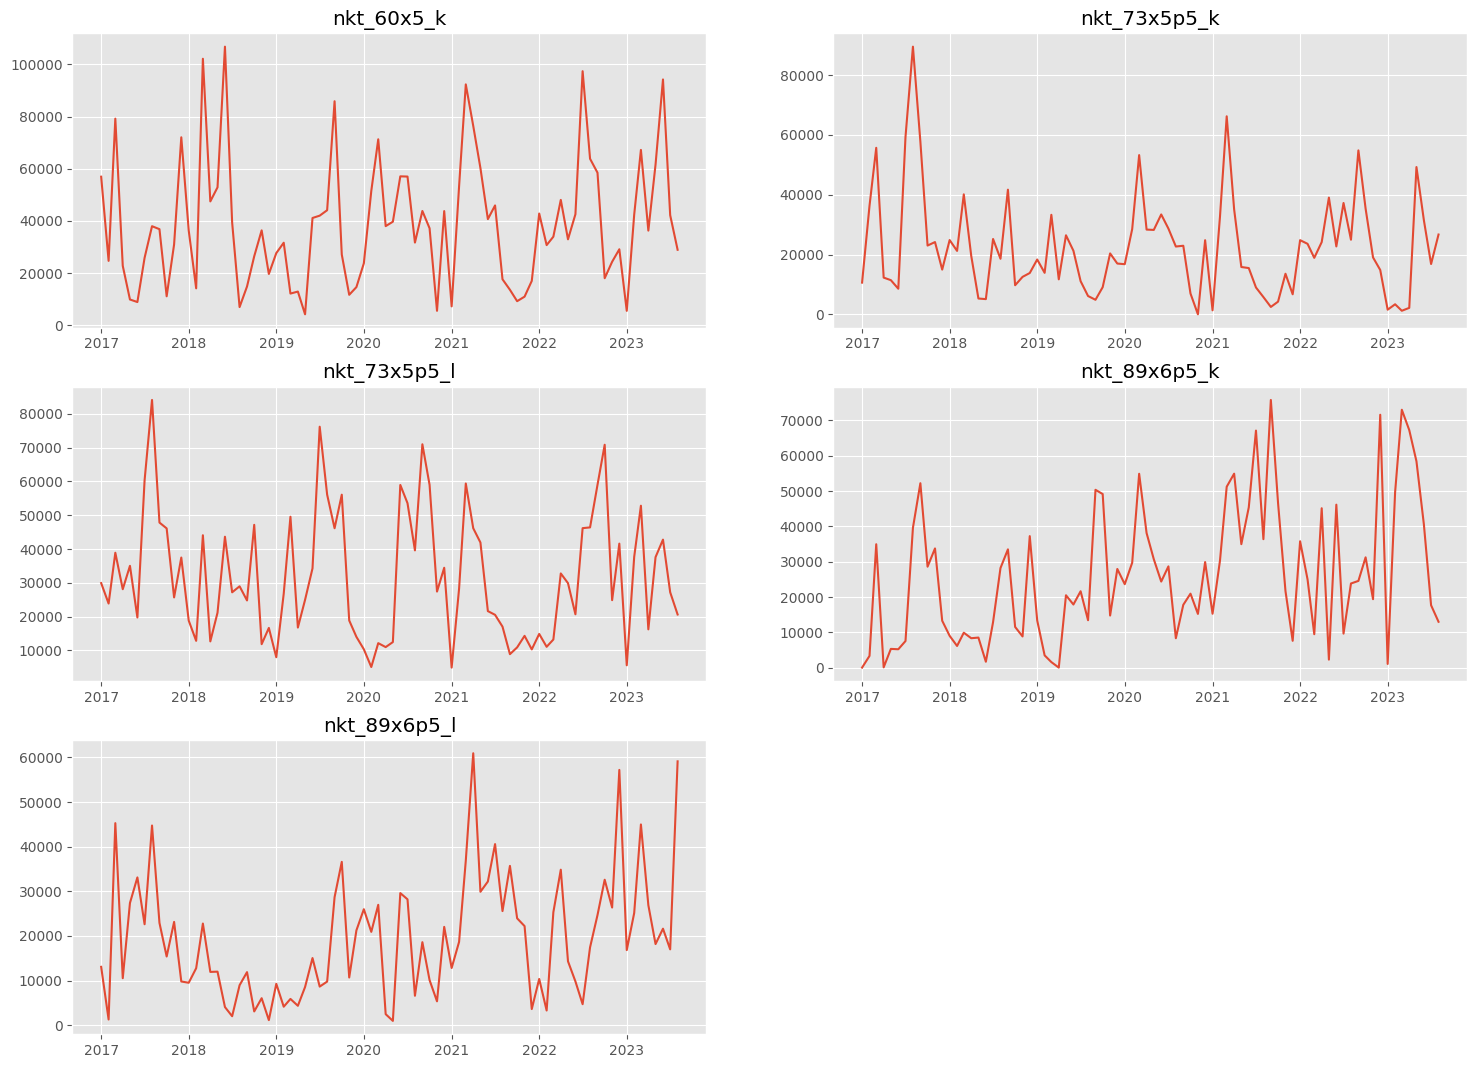

In [193]:
sg_plots(df_hist_groupby)

In [194]:
def merge_df_hist_with_prod_data(df_hist, prod_data, df_req, date_column):
    """Объединение производственных данных с данными потребления"""
    
    df_new = pd.DataFrame()

    # Определяем необходимый временной диапазон
    date_range = pd.DataFrame({'year_and_month':pd.date_range(start='2017-01', periods=80, freq=pd.offsets.MonthBegin(1))})
    
    # Для каждой синтез-группы формируем датафрейм и затем объединяем в один общий
    for sg in df_hist['analog_group'].unique():
        df_hist_sg = df_hist[df_hist['analog_group']==sg]
        df_hist_sg = df_hist_sg.merge(date_range, on='year_and_month', how='right')
        df_hist_sg['analog_group'] = df_hist_sg['analog_group'].fillna(sg)
        df_hist_sg['quantity'] = df_hist_sg['quantity'].fillna(0)

        # Формируем фичи: лаги по данным потребления (назад на 12 месяцев)
        for i in range(1, 13):
            df_hist_sg[f'quantity_{-i}'] = df_hist_sg.groupby('analog_group')['quantity'].transform(lambda x: x.shift(i))

        # Объединяем датафрейм историчксих потреблений для синтез-группы с производственными данными
        df = prod_data.merge(df_hist_sg, how='left',on=date_column)
        df['analog_group'] = df['analog_group'].fillna(sg)
        df = df.fillna(0)

        # Объединяем все отдельные по синтез-группе датафреймы в один
        df_new = pd.concat([df_new, df])
        
    df_new = df_new.merge(df_req, on=['analog_group','year_and_month'], how='left').fillna(0)
    df_new = df_new.drop('year_and_month',axis=1)
        
    return df_new

In [195]:
# Объединенные с производственными данными датасеты
df_full = merge_df_hist_with_prod_data(df_hist_groupby, df_prod_new, df_req_groupby, 'year_and_month')

In [196]:
df_full

,dt,"Ввод доб. скважин из бездействия, шт._Ввод из ДК","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ГРП","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ЗБС","Время простоя доб. скважин, сут_Возвраты","Время работы доб. скважин, сут_Базовая добыча","Выбытие вдз. скважин, скв._ДФ ВДЗ","Выбытие доб. скв. в ППД, шт_Ввод_ННС","Выбытие доб. скв. в ППД, шт_Выбытие ППД","Выбытие доб. скважин в бездействие, скв._Ввод из ДК",...,quantity_-4,quantity_-5,quantity_-6,quantity_-7,quantity_-8,quantity_-9,quantity_-10,quantity_-11,quantity_-12,bmu_request
0,2020-01-01,1.0,1.916667,0.958333,0.0,81909.791656,2.0,0.0,8.0,1.0,...,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,31635.935,27650.200,282903.0
1,2020-02-01,0.0,12.666667,7.166667,0.0,78236.583324,3.0,0.0,7.0,0.0,...,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,31635.935,0.0
2,2020-03-01,0.0,0.583333,21.083333,0.0,83810.291660,2.0,0.0,16.0,0.0,...,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,0.0
3,2020-04-01,0.0,5.416667,5.375000,0.0,80798.624989,5.0,0.0,16.0,0.0,...,14615.303,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,45218.0
4,2020-05-01,0.0,3.375000,0.333333,0.0,71607.916444,2.0,0.0,12.0,0.0,...,23738.386,14615.303,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2025-08-01,0.0,8.060000,41.695000,0.0,73798.445000,0.0,0.0,11.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
356,2025-09-01,0.0,7.800000,40.350000,0.0,71388.300000,0.0,1.0,12.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
357,2025-10-01,0.0,8.060000,41.695000,0.0,72684.925000,0.0,2.0,8.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
358,2025-11-01,0.0,7.800000,40.350000,0.0,68081.940000,0.0,1.0,10.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


In [197]:
def get_season(month):
    """Функция, возвращающая время года"""
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3
    
def filter_numeric_cols(col):
    """Выбор признаков без quantity"""

    if 'quantity' in col:
        return False
    else:
        return True

def create_quantity_features(df):
    """Генерация фичей по производственным данным"""
    
    # Все числовые колонки
    numeric_cols = list(df.select_dtypes(include='float64').columns)
    numeric_cols = filter(filter_numeric_cols, numeric_cols)
    
    # Временные фичи
    df['month'] = df['dt'].dt.month
    df['season'] = df['month'].apply(get_season)
    
    # Фичи с лагами за 12 месяцев назад по всем колонкам
    for col in numeric_cols:
        for i in range(1, 13):
            df[f'{col}_{-i}'] = df.groupby('analog_group')[col].transform(lambda x: x.shift(i))
        
    return df

In [198]:
df_features = create_quantity_features(df_full)

In [199]:
# Обрезаем по необходимой дате
df_final = df_features[(df_features['dt']>='2020.01.01') & (df_features['dt']<='2024.12.01')].fillna(0)

In [200]:
def prepare_analog_group(df):
    """Подготовка поля синтез-группы для обучения"""

    # Параметр синтез-группы в начало Датафрейма
    sg_col = df['analog_group']
    df = df.drop('analog_group',axis=1)
    df.insert (0, 'analog_group', sg_col)

    return df

In [201]:
df_final = prepare_analog_group(df_final)

In [202]:
df_final

,analog_group,dt,"Ввод доб. скважин из бездействия, шт._Ввод из ДК","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ГРП","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ЗБС","Время простоя доб. скважин, сут_Возвраты","Время работы доб. скважин, сут_Базовая добыча","Выбытие вдз. скважин, скв._ДФ ВДЗ","Выбытие доб. скв. в ППД, шт_Ввод_ННС","Выбытие доб. скв. в ППД, шт_Выбытие ППД",...,bmu_request_-3,bmu_request_-4,bmu_request_-5,bmu_request_-6,bmu_request_-7,bmu_request_-8,bmu_request_-9,bmu_request_-10,bmu_request_-11,bmu_request_-12
0,nkt_60x5_k,2020-01-01,1.0,1.916667,0.958333,0.0,81909.791656,2.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000
1,nkt_60x5_k,2020-02-01,0.0,12.666667,7.166667,0.0,78236.583324,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000
2,nkt_60x5_k,2020-03-01,0.0,0.583333,21.083333,0.0,83810.291660,2.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000
3,nkt_60x5_k,2020-04-01,0.0,5.416667,5.375000,0.0,80798.624989,5.0,0.0,16.0,...,282903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000
4,nkt_60x5_k,2020-05-01,0.0,3.375000,0.333333,0.0,71607.916444,2.0,0.0,12.0,...,0.0,282903.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,nkt_89x6p5_l,2024-08-01,0.0,8.060000,41.695000,0.0,74271.691000,0.0,3.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,228789.16,15044.184,0.000
344,nkt_89x6p5_l,2024-09-01,0.0,7.800000,40.350000,0.0,71831.280000,0.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,228789.160,15044.184
345,nkt_89x6p5_l,2024-10-01,0.0,8.060000,41.695000,0.0,73127.822000,0.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,228789.160
346,nkt_89x6p5_l,2024-11-01,0.0,7.800000,40.350000,0.0,68467.886000,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000


### Отбор признаков

In [203]:
def func_feature_selection(df, method, features_number):
    """Выбор лучших фичей"""

    X_ = df.loc[:, ~df.columns.str.startswith('quantity')].drop(columns=['analog_group']).set_index('dt')
    y_ = df.loc[:, 'quantity']
    
    best_features = FeatureSelection(method=method).filter_X(X=X_,y=y_, n_features=features_number).columns.tolist()

    return best_features

In [204]:
best_features = func_feature_selection(df_final, 'pearson', 100)

[Feature Selection] pearson completed. Out shape = (300, 100). Total time = 0.01s


### Обучение

Baseline:
* CatBoost
* Рекурентные нейросети
* AutoML

In [205]:
# Импорт основных библиотек для обучения
import catboost as cb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import optuna
from sklearn import metrics, tree, ensemble, linear_model
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
from catboost.metrics import MAPE, RMSE, Quantile
import pickle
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


In [206]:
def train_test_split_dataset(df, best_features):
    """Разделение датасета на обучающую и тестовую выборку"""

    
    le = LabelEncoder()

    best_features.append('analog_group')

    train = df[(df['dt']>='2020-01-01')&(df['dt']<='2022-08-01')].drop('dt',axis=1)
    test = df[(df['dt']>='2022-09-01')&(df['dt']<='2023-08-01')]

    train['analog_group'] = le.fit_transform(train['analog_group'])

    x_train = train[best_features]
    y_train = train['quantity']

    x_test = test[best_features]
    x_test['analog_group'] = le.fit_transform(x_test['analog_group'])

    y_test = test[['quantity','analog_group','dt']].set_index('dt')

    return x_train, x_test, y_train, y_test

In [207]:
x_train, x_test, y_train, y_test = train_test_split_dataset(df_final, best_features)

In [208]:
def rmse_table(y_true, y_pred):
    """RMSE ошибка"""

    return ((mean_squared_error(y_true, y_pred))**(1/2)).round(2)

def mape_table(y_true, y_pred):
    """MAPE ошибка"""

    return np.mean(np.abs((y_true - y_pred) / y_true))

### Optuna

In [227]:
def optuna_optimize(trial):
  """Функция оптизации optuna"""

  if algorithm == 'lasso':
    model = linear_model.Lasso(
        alpha = trial.suggest_float("alpha", 0.0001, 10),
        random_state = 33
    )
  elif algorithm == 'ridge':
    model = linear_model.Lasso(
        alpha = trial.suggest_float("alpha", 0.0001, 10),
        random_state = 33
    )
  elif algorithm == 'ensemble.RandomForestRegressor':
    model = ensemble.RandomForestRegressor(
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, 10),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 9, 1),
        max_depth = trial.suggest_int('max_depth', 1, 30, 1),
        criterion = trial.suggest_categorical('criterion',['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
        random_state=33,
        n_jobs=-1
    )
  elif algorithm == 'XGBRegressor':
    model = XGBRegressor(
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        gamma=trial.suggest_float("gamma", 0.5, 5),
        subsample=trial.suggest_float("subsample", 0.6, 1),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1),
        max_depth=trial.suggest_int("max_depth", 3, 15),
        n_estimators=trial.suggest_int("n_estimators", 10, 2000),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1)
    )
  elif algorithm == 'CatBoostRegressor':
    model = CatBoostRegressor(
        iterations = trial.suggest_int('iterations', 100, 1500),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1),
        depth = trial.suggest_int('depth', 3, 12),
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 100),
        cat_features=['analog_group'],
        verbose=False
    )
  # обучаем модель
  model.fit(x_train, y_train)
    
    # Вычисление метрики для оптимизации
  y_pred = model.predict(x_test)
  rmse = mean_squared_error(y_test['quantity'], y_pred, squared=False)
  return rmse

In [233]:
def train_optuna(algorithms, is_save):
    """Подбор гиперпараметров через optuna"""

    for algorithm_name in algorithms:
        # optuna.logging.set_verbosity(optuna.logging.WARNING)
        algorithm = algorithm_name
        study = optuna.create_study(direction="minimize")
        study.optimize(optuna_optimize, n_trials=1, n_jobs=-1)

        # Сохранение параметров
        if is_save == True:
            with open(f'params/{algorithm}_params.pkl', 'wb') as f: pickle.dump(study.best_params, f)

In [234]:
algorithms = ['lasso','ridge','ensemble.RandomForestRegressor','XGBRegressor','CatBoostRegressor']
train_optuna(algorithms, is_save = True)

[I 2023-10-01 20:14:14,124] A new study created in memory with name: no-name-ae66b9db-69a2-421a-b8ae-21fce976868e
[I 2023-10-01 20:14:29,692] Trial 0 finished with value: 22181.468211791995 and parameters: {'iterations': 1494, 'learning_rate': 0.0967218022532169, 'depth': 5, 'l2_leaf_reg': 7.367081452810928}. Best is trial 0 with value: 22181.468211791995.
[I 2023-10-01 20:14:29,695] A new study created in memory with name: no-name-4712b719-706f-4b5b-8f9a-75029e63cee2
[I 2023-10-01 20:14:49,515] Trial 0 finished with value: 21726.330563309555 and parameters: {'iterations': 554, 'learning_rate': 0.014965855372388284, 'depth': 10, 'l2_leaf_reg': 16.936307125443886}. Best is trial 0 with value: 21726.330563309555.
[I 2023-10-01 20:14:49,518] A new study created in memory with name: no-name-77398545-3112-493c-bfee-4d717df3c487
[I 2023-10-01 20:14:56,462] Trial 0 finished with value: 22040.640819840704 and parameters: {'iterations': 468, 'learning_rate': 0.07228837451615665, 'depth': 7, 'l2

In [ ]:
def train_models():
    model = CatBoostRegressor(**study.best_params,random_state=42, cat_features=['analog_group'], verbose=False)
    model.fit(x_train, y_train)
    with open(f'models/catboost_model.pkl', 'wb') as f: pickle.dump(model_catboost, f)

In [172]:
model_catboost = CatBoostRegressor(**study.best_params,random_state=42, cat_features=['analog_group'], verbose=False)
model_catboost.fit(x_train, y_train)
with open(f'models/catboost_model.pkl', 'wb') as f: pickle.dump(model_catboost, f)

In [173]:
def create_predict_tables(model, model_name):
    """Создание таблиц предсказаний"""

    # Исходные таблицы
    y_test_table = y_test
    y_train_table = df_full

    # Предсказания на трейне и тесте 
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)
    
    # Датафрейм теста
    y_test_table['predict_test'] = y_test_predict
    y_test_table['model'] = model_name

    # Датафрейм трейна
    y_train_table = y_train_table[(y_train_table['dt']<'2022.09.01') & (y_train_table['dt']>='2020.01.01')][['analog_group','quantity','dt']].set_index('dt')
    y_train_table['predict_train'] = y_train_predict

    return y_train_table, y_test_table

In [174]:
y_train_table_catboost, y_test_table_catboost = create_predict_tables(model_catboost, 'CatBoost')

In [175]:
def results_plot(y_train_table, y_test_table, save_fig):
    """Визуализация результатов"""

    plt.figure(figsize=(18,16))

    sg_unique = y_test_table['analog_group'].unique()
    model_name = y_test_table['model'].max()

    for i in range(len(sg_unique)):
        y_train_table_sg = y_train_table[y_train_table['analog_group']==sg_unique[i]]
        y_test_table_sg = y_test_table[y_test_table['analog_group']==sg_unique[i]]
            
        plt.subplot(3,2,i+1)
        plt.title(f'{sg_unique[i]}_{model_name}')
        plt.plot(y_train_table_sg['quantity'], linewidth=3, color='#686963', label='True (training)')
        plt.plot(y_train_table_sg['predict_train'], linewidth=3, color="#DB5461", label='Predict (training)')
        plt.axvline(y_train_table_sg.index[-1], color ='blue', lw = 3, alpha = 0.9, label='Test')
        plt.plot(y_test_table_sg['quantity'], linewidth=3, color='#686963', label='True (holdout)')
        plt.plot(y_test_table_sg['predict_test'], linewidth=3, color="#DB5461", label='Prediction (holdout)')
        plt.legend(loc=2, facecolor='white', framealpha=1)

        # Сохраняем график
        if save_fig == True:
            plt.savefig(f'plots/{sg_unique[i]}_{model_name}.png', facecolor='white', dpi=200)

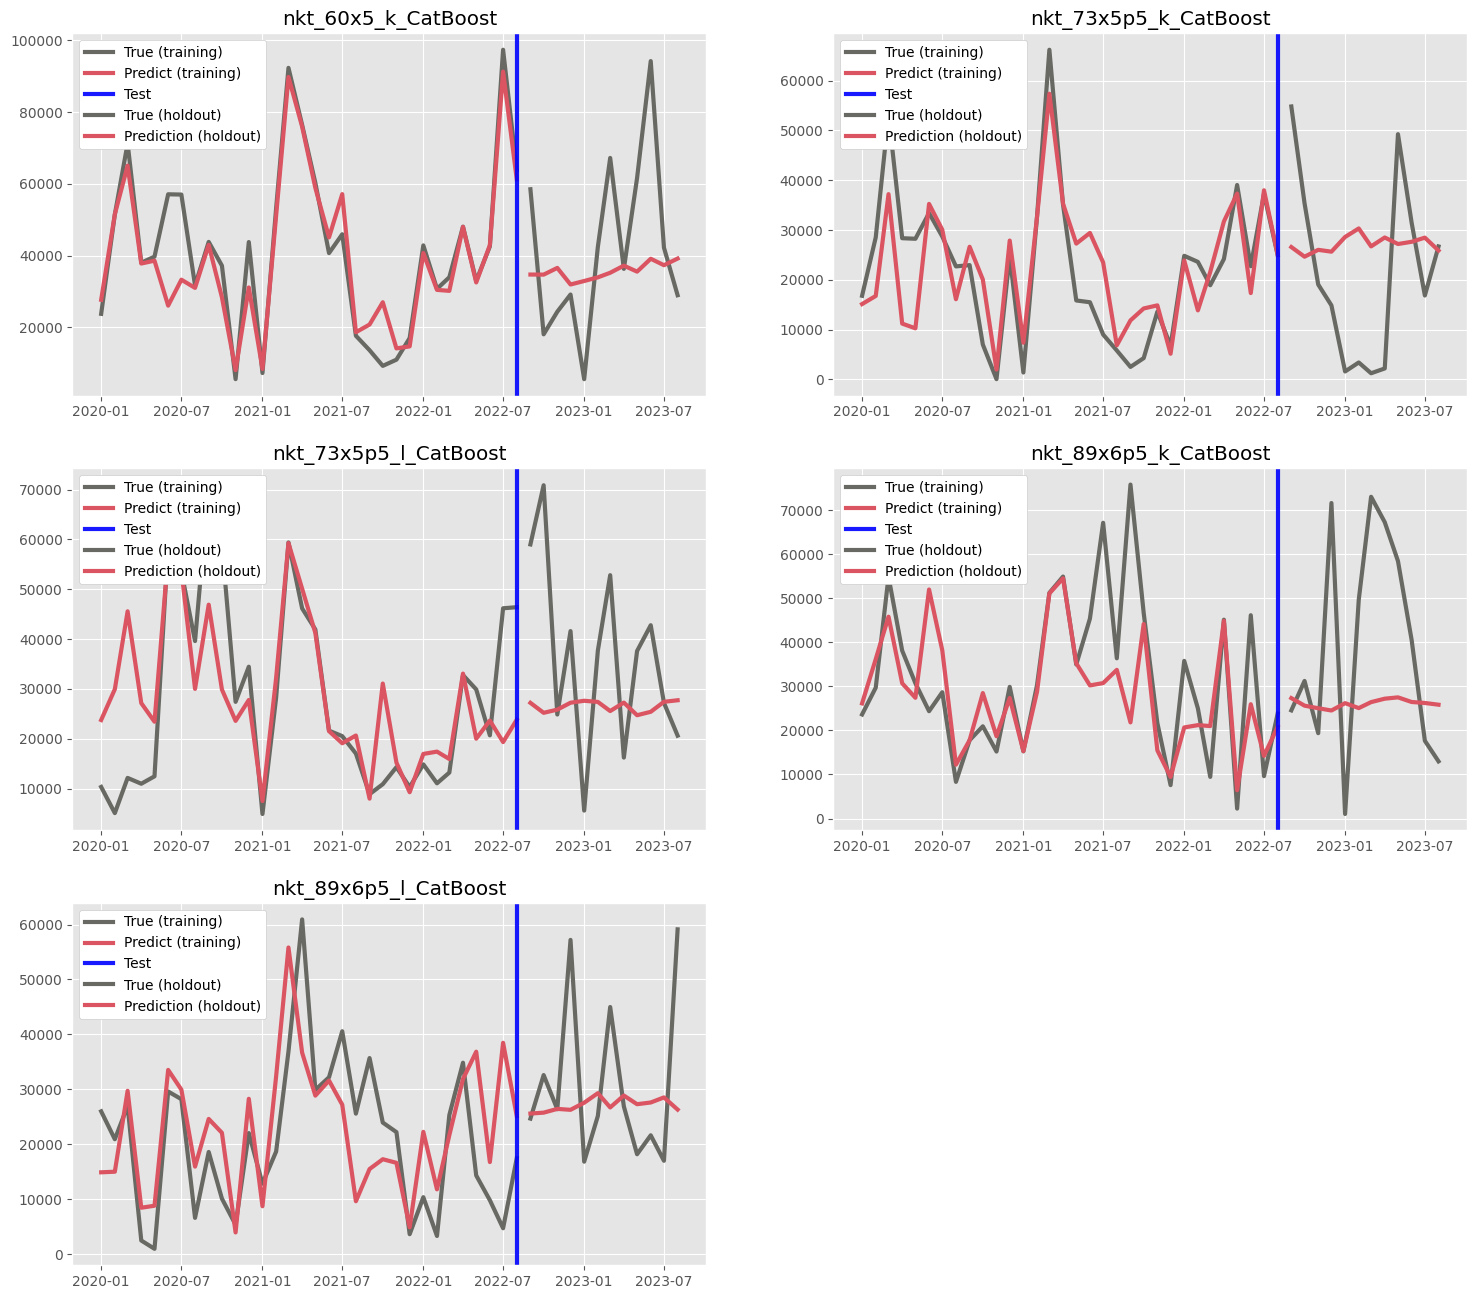

In [176]:
results_plot(y_train_table_catboost, y_test_table_catboost, save_fig = True)